<a href="https://colab.research.google.com/github/milipaget/PASA-2023/blob/main/TP_4_PASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Trabajo Práctico N°4 - Procesamiento de arreglos**
> ### Paget, Milagros 61449
> ### Voss, María de Guadalupe 61583

En este trabajo se analizarán señales provenientes de 15 micrófonos distintos.

In [16]:
#Se importan las bibliotecas necesarias.
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
from scipy.linalg import solve_toeplitz
import scipy.signal as signal
from scipy.fft import fft, fftfreq, fftshift

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
#Se carga el archivo de audio
fs, signal = wavfile.read('/content/drive/My Drive/TP4 PASA/mtms-arrC1A.wav')
signal = np.swapaxes(signal,0,1) # Fila son canales, columnas son tiempo
signal = signal/np.max(signal)
print(fs)

16000


In [19]:
d1 = 0.04 #En m: arreglo de 3, 4, 5, 6, 7, 8, 9, 10 y 11
d2 = 0.08 #En m: arreglo de 1, 2, 3, 5, 7, 9, 11, 12 y 13
d3 = 0.16 #En m: arreglo de 0, 1, 3, 7, 11, 13 y 14
fc = 2000 #Hz

In [20]:
array1 = [3,4,5,6,7,8,9,10,11]
array2 = [1,2,3,5,7,9,11,12,13]
array3 = [0,1,3,7,11,13,14]

In [21]:
def FIRFilter(inputSignal, f, fs, order=100, window='hamming'):
    arrayDemod = np.exp(-2j*np.pi*fc/fs*np.arange(len(inputSignal))) * inputSignal
    b = scipy.signal.firwin(order + 1, 0.02*fc, window=window, fs=fs) # B = 2% de fc

    # Aplicar el filtro FIR
    filteredSignal = scipy.signal.lfilter(b, 1, arrayDemod)

    return filteredSignal

## Espectrograma de frecuencia espacial

Dado que la longitud de onda λ es 343m/s / 2000Hz = 0.1715m el arreglo de sensores óptimo es en el cual los sensores se encuentran espaciados 8 cm. Esto se debe a que el criterio de Nyquist establece que d ≤ λ/2.

Por otro lado, para seleccionar el ancho de banda se tuvo en cuenta que se cumpla la condición de banda angosta, por ende se tomó 40Hz (2% de fc).

In [42]:
# Demodular y filtrar la señal
signal_filt = np.zeros(np.shape(signal), dtype=np.complex_)
for i, val in enumerate(signal):
    signal_filt[i] = FIRFilter(signal[i], fc, fs, 50, 'bartlett')

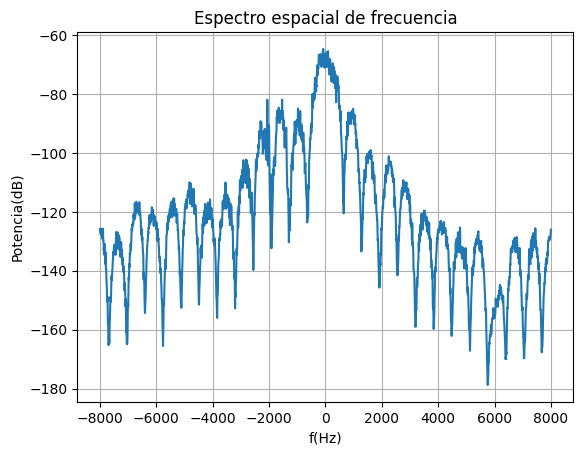

In [43]:
a, b = plt.mlab.psd(signal_filt[1], Fs=fs, NFFT=signal[0].size//200)
plt.title('Espectro espacial de frecuencia')
plt.plot(b,10*np.log10(a))
plt.xlabel('f(Hz)')
plt.ylabel('Potencia(dB)')
plt.grid()

plt.show()


In [61]:
#Se separa el audio en fragmentos donde no haya voz del locutor
inicio = (fs*np.array([22, 25.8, 28.1, 31])).astype(int)
fin = (fs*np.array([23.1,25.8,28.1,31])).astype(int)

i_n_filt = signal_filt[array2]
interferencia = np.zeros(i_n_filt[:, inicio[1]:fin[1]].shape)
for i, item in enumerate(inicio):
    interferencia = np.concatenate((interferencia, i_n_filt[:, inicio[i]:fin[i]]), axis=1)

In [62]:
signalFFT = np.zeros((32, signal_filt.shape[1]), dtype=np.complex_)

for t in range(len(signal_filt[0])):
    signalFFT[:,t], _ = plt.mlab.psd(signal_filt[array2, t],
                                            Fs=1,
                                            NFFT=signal_filt[array2, t].size,
                                            pad_to=32,
                                            sides='twosided')

signalFFT /=  signal_filt.shape[1]

In [63]:
interferenciaFFT = np.zeros((32, interferencia.shape[1]), dtype=np.complex_)

for t in range(len(interferencia[0])):
    interferenciaFFT[:, t], _ = plt.mlab.psd(interferencia[: , t],
                                            Fs=1,
                                            NFFT=signal_filt[: , t].size,
                                            pad_to=32,
                                            sides='twosided')
interferenciaFFT /= len(interferencia[0])

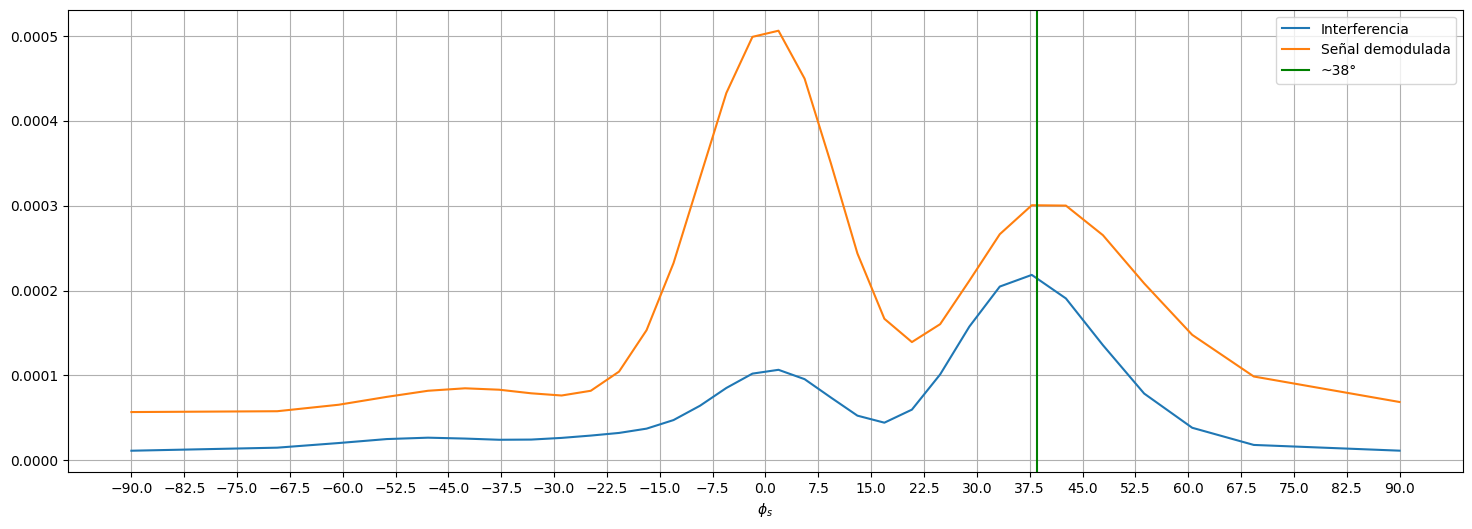

In [68]:
plt.figure(figsize=(18, 6))
phi_ax = 180/np.pi * np.arcsin(np.linspace(-1, 1, len(interferenciaFFT)))
plt.plot(phi_ax , np.abs(interferenciaFFT).sum(axis=1), label='Interferencia')
plt.xticks(np.linspace(-90, 90, 24+1))
plt.plot(phi_ax , np.abs(signalFFT).sum(axis=1), label='Señal demodulada')
plt.xlabel('$\phi_s$')
plt.axvline(x = 38.5, color='g', label='~38°')
plt.legend()
plt.grid()
plt.show()

Se observa que hay señales provenientes de un ángulo cercano a 0° y otra de aproximadamente 38°. Analizando fragmentos únicamente con interferencias podemos afirmar que las señales son de la voz del locutor y de la radio AM correspondientemente.

## Beamformer óptimo SMI

In [23]:
def responseVector(m, phi, d, l):
  return ( 1/np.sqrt(m) * np.exp(-2j * np.pi * d * np.sin(phi) / l * np.arange(m)) ).reshape((m, 1))

In [49]:
N = interferencia.shape[0]
Rin = np.zeros((N, N), dtype=np.complex_)

for i in range(interferencia.shape[1]):
    Raux = np.matmul(np.conj(interferencia[:, i].reshape((N, 1))) , interferencia[:, i].reshape((1, N)))
    Rin += Raux

Rin = Rin / (interferencia.shape[1])

inv_Rin = np.linalg.inv(Rin)

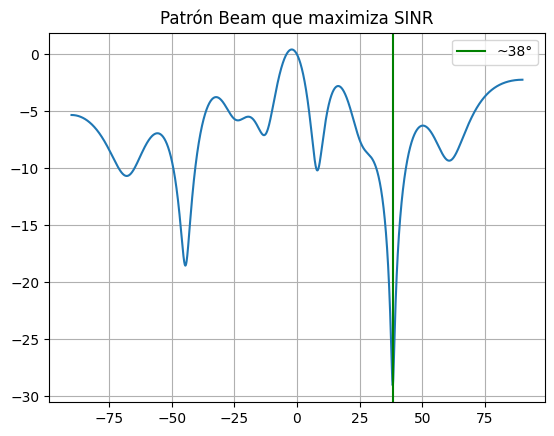

In [70]:
l = 343/fc #longitud de onda, 343m/s es la velocidad del sonido
M = len(array2)

vs = responseVector(M, 0, d2, l)
vs_h = np.conj(vs.transpose())

c_o = np.matmul(inv_Rin,vs) / np.matmul( np.matmul(vs_h, inv_Rin), vs )[0][0]

C = []
for phi in np.linspace(-np.pi/2, np.pi/2, 5000):
    v = responseVector(M, phi, d2, l)
    c_o_h = np.conj(c_o.transpose())
    C.append((np.dot(c_o_h, v)).flatten())

plt.plot(np.linspace(-90, 90, 5000), 10*np.log10(np.abs(C)**2))
plt.axvline(x = 38.5, color='g', label='~38°')
plt.legend()
plt.grid()
plt.title('Patrón Beam que maximiza SINR')
plt.show()


Como podemos ver, donde se encuentra la voz del locutor (0°) está el lóbulo de mayor ganancia. A su vez notamos que se encuentra un cero del patrón beam en el ángulo de donde proviene la interferencia (aproximadamente 38°).